Epoch 50/10000, Loss: 5.6802
Epoch 100/10000, Loss: 5.3819
Epoch 150/10000, Loss: 5.3635
Epoch 200/10000, Loss: 5.3667
Epoch 250/10000, Loss: 5.2695
Epoch 300/10000, Loss: 5.2047
Epoch 350/10000, Loss: 5.1473
Epoch 400/10000, Loss: 5.0444
Epoch 450/10000, Loss: 5.0318
Epoch 500/10000, Loss: 4.9398
Epoch 550/10000, Loss: 4.8967
Epoch 600/10000, Loss: 4.7479
Epoch 650/10000, Loss: 4.6720
Epoch 700/10000, Loss: 4.6799
Epoch 750/10000, Loss: 4.5301
Epoch 800/10000, Loss: 4.4075
Epoch 850/10000, Loss: 4.3366
Epoch 900/10000, Loss: 4.4338
Epoch 950/10000, Loss: 4.4099
Epoch 1000/10000, Loss: 4.3968
Epoch 1050/10000, Loss: 4.3243
Epoch 1100/10000, Loss: 4.3686
Epoch 1150/10000, Loss: 4.4727
Epoch 1200/10000, Loss: 4.5064
Epoch 1250/10000, Loss: 4.4702
Epoch 1300/10000, Loss: 4.4930
Epoch 1350/10000, Loss: 4.4865
Epoch 1400/10000, Loss: 4.4755
Epoch 1450/10000, Loss: 4.3609
Epoch 1500/10000, Loss: 4.2917
Epoch 1550/10000, Loss: 4.2765
Epoch 1600/10000, Loss: 4.1330
Epoch 1650/10000, Loss: 3.95

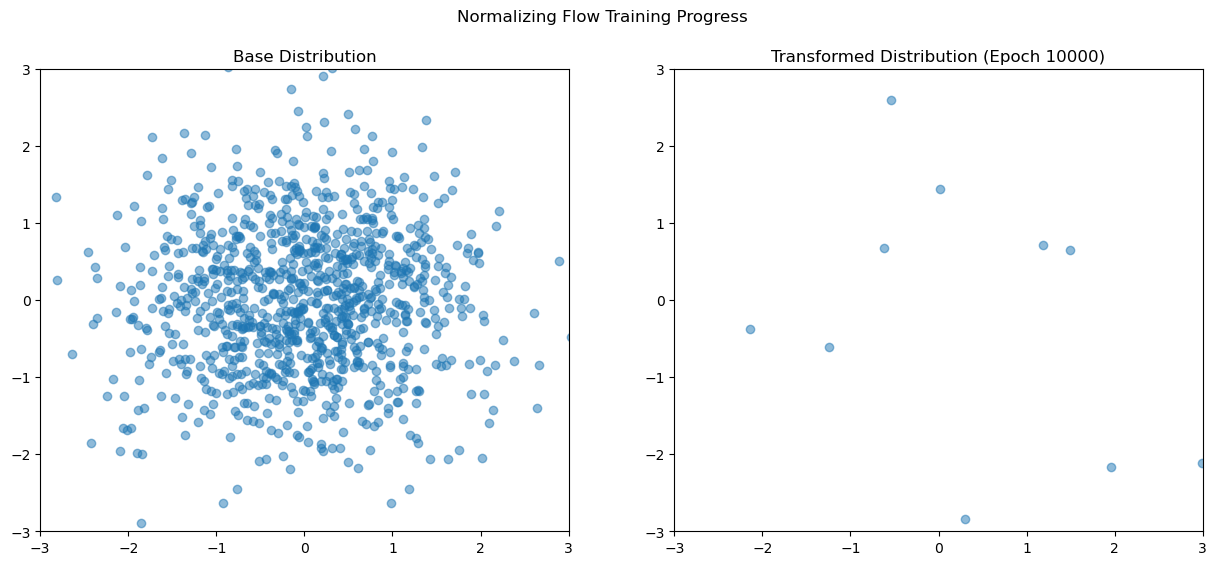

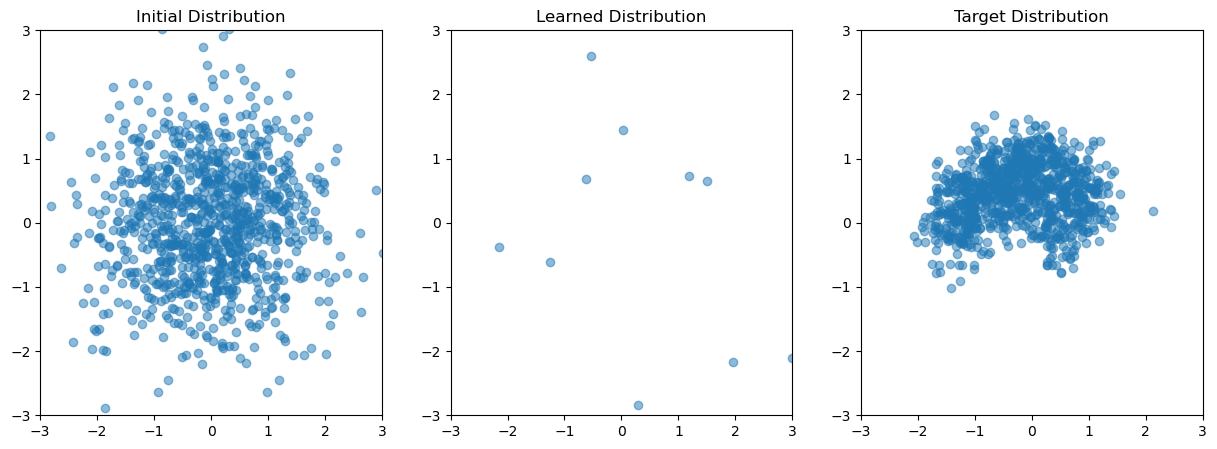

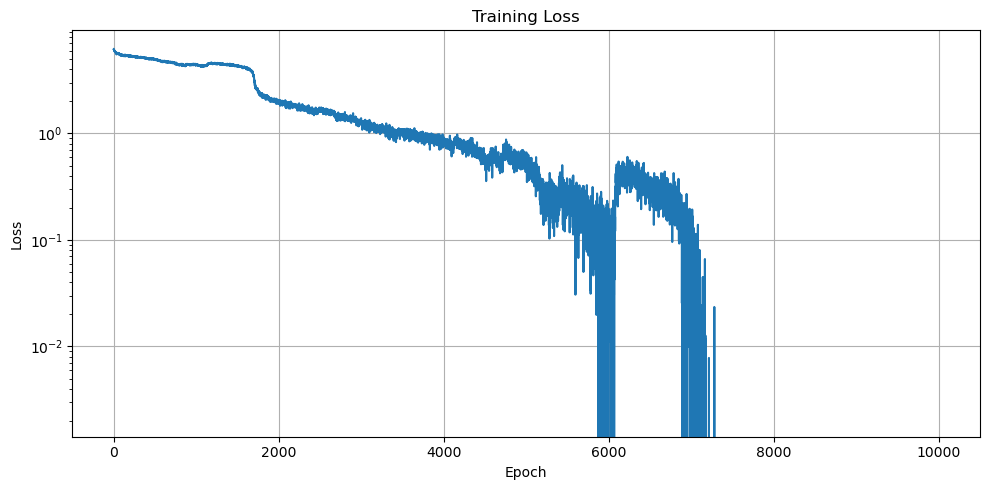

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

class PlanarFlow(nn.Module):
    """
    Implements a single layer of planar flow transformation:
    f(z) = z + u * tanh(w^T * z + b)
    """
    def __init__(self, dim=2):
        super().__init__()
        self.w = nn.Parameter(torch.randn(dim))
        self.u = nn.Parameter(torch.randn(dim))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        # Transform the input
        activation = torch.tanh(torch.sum(self.w * z, dim=1, keepdim=True) + self.b)
        return z + self.u * activation
    
    def log_det_jacobian(self, z):
        # Compute log determinant of Jacobian for change of variables
        activation = torch.tanh(torch.sum(self.w * z, dim=1, keepdim=True) + self.b)
        psi = (1 - activation**2) * self.w
        det = 1 + torch.sum(self.u * psi, dim=1, keepdim=True)
        epsilon = 1e-6
        return torch.log(torch.abs(det) + epsilon)

        # return torch.log(torch.abs(det))

class NormalizingFlow(nn.Module):
    def __init__(self, dim=2, n_flows=4):
        super().__init__()
        self.flows = nn.ModuleList([PlanarFlow(dim) for _ in range(n_flows)])
        
    def forward(self, z):
        log_det_sum = torch.zeros(z.size(0), 1).to(z.device)
        
        for flow in self.flows:
            log_det_sum += flow.log_det_jacobian(z)
            z = flow(z)
            
        return z, log_det_sum

def generate_moons_data(n_samples=1000):
    """Generate two moons dataset"""
    radius = 1
    width = 0.3
    
    # Generate angles
    angles = np.linspace(0, np.pi, n_samples // 2)
    
    # Generate first moon
    x1 = radius * np.cos(angles)
    y1 = radius * np.sin(angles)
    
    # Generate second moon
    x2 = radius * np.cos(angles) - 0.5
    y2 = radius * np.sin(angles) - 0.4
    
    X = np.vstack([np.column_stack([x1, y1]), np.column_stack([x2, y2])])
    X += np.random.normal(0, width, X.shape)
    
    return torch.FloatTensor(X)

# Set up visualization
def setup_plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Normalizing Flow Training Progress')
    return fig, (ax1, ax2)

def plot_distribution(ax, samples, title):
    ax.clear()
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(title)

# Training setup
n_samples = 1000
model = NormalizingFlow(dim=2, n_flows=4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create target data
target_data = generate_moons_data(n_samples)

# Setup visualization
fig, (ax1, ax2) = setup_plot()
plot_frames = []

# Training loop
def train_step(model, optimizer, real_data):
    optimizer.zero_grad()
    
    # Sample from base distribution (standard normal)
    z0 = torch.randn(n_samples, 2)
    
    # Transform samples through flows
    zk, log_det = model(z0)
    
    # Compute loss (negative log likelihood)
    # prior_logprob = -0.5 * torch.sum(z0**2, dim=1, keepdim=True) - torch.log(torch.tensor(2 * np.pi))
    prior_logprob = -0.5 * torch.sum(z0**2, dim=1, keepdim=True) - z0.size(1) * torch.log(torch.tensor(2 * np.pi))

    loss = -torch.mean(prior_logprob + log_det)
    
    loss.backward()
    optimizer.step()
    
    return loss.item(), z0, zk

# Train the model
n_epochs = 10000
viz_frequency = 50  # How often to update the visualization
losses = []

for epoch in range(n_epochs):
    loss, z0, zk = train_step(model, optimizer, target_data)
    losses.append(loss)
    
    if (epoch + 1) % viz_frequency == 0:
        # Update visualization
        plot_distribution(ax1, z0.detach().numpy(), 'Base Distribution')
        plot_distribution(ax2, zk.detach().numpy(), f'Transformed Distribution (Epoch {epoch+1})')
        plt.draw()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

# Final visualization
plt.figure(figsize=(15, 5))

# Plot final distributions
plt.subplot(131)
plt.scatter(z0[:, 0].detach().numpy(), z0[:, 1].detach().numpy(), alpha=0.5)
plt.title('Initial Distribution')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(132)
plt.scatter(zk[:, 0].detach().numpy(), zk[:, 1].detach().numpy(), alpha=0.5)
plt.title('Learned Distribution')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(133)
plt.scatter(target_data[:, 0].numpy(), target_data[:, 1].numpy(), alpha=0.5)
plt.title('Target Distribution')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()